In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os
import glob
import sys
from keras.optimizers import  Adam

# Importing our w-net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import frequency_spatial_network as fsnet

# Importing callbacks and data augmentation utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

#Some code are copied from Souza, Roberto, R. Marc Lebel, and Richard Frayne.
#"A Hybrid, Dual Domain, Cascade of Convolutional Neural Networks for Magnetic Resonance Image Reconstruction." 
#Proceedings of Machine Learning Research–XXXX 1 (2019): 11.
#https://github.com/rmsouza01/CD-Deep-Cascade-MR-Reconstruction
#The data is collected on https://sites.google.com/view/calgary-campinas-dataset


Using TensorFlow backend.
E:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as

In [2]:
# Train Set 
train_path = "./Train/Train/*.npy"
kspace_files_train = np.asarray(glob.glob(train_path))

# Validation set
val_path = "./Val/Val/*.npy"
kspace_files_val = np.asarray(glob.glob(val_path))

indexes = np.arange(kspace_files_train.size,dtype = int)
np.random.shuffle(indexes)
kspace_files_train = kspace_files_train[indexes]


print(kspace_files_train[-1])
print(len(kspace_files_train))

print(kspace_files_val[-1])
print(len(kspace_files_val))

./Train/Train\e14078s3_P02048.7.npy
24
./Val/Val\e14553s5_P44544.7.npy
10


(256, 256)
13056


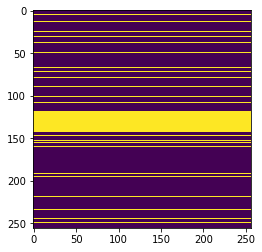

In [3]:
#20%1d mask
res=256
K=[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,0, 0, 0,
 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
D=np.tile(K,[res,1])
D=D.T
imgplot=plt.imshow(D)
print(D.shape)
x_pdf2=D
print((x_pdf2).sum())
#51slice，20%rate

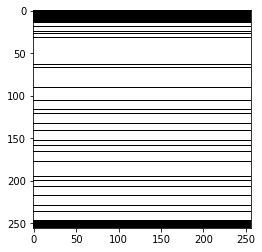

In [4]:
#use no fftshift
var_sampling_mask=1-x_pdf2
var_sampling_mask=np.fft.fftshift(var_sampling_mask)
var_sampling_mask=var_sampling_mask.astype(bool)
plt.figure()
plt.imshow(var_sampling_mask,cmap = "gray")
under_rate = '20'
imshape = (256,256)
norm = np.sqrt(imshape[0]*imshape[1])
nchannels = 2 #complex data real + imag

In [5]:
# Get number of samples
ntrain = 0
for ii in range(len(kspace_files_train)):
    ntrain += np.load(kspace_files_train[ii]).shape[0]

# Load train data    
rec_train = np.zeros((ntrain,imshape[0],imshape[1],2))
kspace_train = np.zeros((ntrain,imshape[0],imshape[1],2))
aux_counter = 0
for ii in range(len(kspace_files_train)):
     aux_kspace = np.load(kspace_files_train[ii])/norm
     aux = aux_kspace.shape[0]   
     aux2 = np.fft.ifft2(aux_kspace[:,:,:,0]+1j*aux_kspace[:,:,:,1])
     rec_train[aux_counter:aux_counter+aux,:,:,0] = aux2.real
     rec_train[aux_counter:aux_counter+aux,:,:,1] = aux2.imag
     kspace_train[aux_counter:aux_counter+aux,:,:,0] = aux_kspace[:,:,:,0]
     kspace_train[aux_counter:aux_counter+aux,:,:,1] = aux_kspace[:,:,:,1]
     aux_counter+=aux

# Shuffle training    
indexes = np.arange(rec_train.shape[0],dtype = int)
np.random.shuffle(indexes)
rec_train = rec_train[indexes]

kspace_train[:,var_sampling_mask,:] = 0 # undersample k-space
# kspace_train = (kspace_train-stats[0])/stats[1]

# save k-space and image domain stats
stats = np.zeros(4)
stats[0] = kspace_train.mean()
stats[1] = kspace_train.std()
# aux = np.abs(rec_train[:,:,:,0] +1j*rec_train[:,:,:,1])
aux = rec_train
stats[2] = aux.mean()
stats[3] = aux.std()
np.save("../Data/stats_fs_unet_norm_2c_R5" + under_rate + ".npy",stats)

print("Number of training samples", rec_train.shape[0])
kspace_train = 0 # release memory

Number of training samples 4084


In [6]:
# if not normal
# Get number of samples
nval = 0
for ii in range(len(kspace_files_val)):
    nval += np.load(kspace_files_val[ii]).shape[0]

kspace_val = np.zeros((nval,imshape[0],imshape[1],nchannels))
rec_val = np.zeros((nval,imshape[0],imshape[1],2))
aux_counter = 0
for ii in range(len(kspace_files_val)):
    aux_kspace = np.load(kspace_files_val[ii])/norm
    aux = aux_kspace.shape[0]   
    kspace_val[aux_counter:aux_counter+aux] = aux_kspace
    rec_val[aux_counter:aux_counter+aux,:,:,0] = \
    np.real(np.fft.ifft2(aux_kspace[:,:,:,0]+1j*aux_kspace[:,:,:,1]))
    rec_val[aux_counter:aux_counter+aux,:,:,1] = \
    np.imag(np.fft.ifft2(aux_kspace[:,:,:,0]+1j*aux_kspace[:,:,:,1]))
    aux_counter+=aux

# Undersampling kspace
kspace_val2 = kspace_val.copy()
kspace_val[:,var_sampling_mask,:] = 0
kspace_val = (kspace_val-stats[0])/stats[1]

print("Number of samples", kspace_val.shape[0])
print("Kspace under stats", kspace_val.mean(),kspace_val.std())
print("Kspace full stats", kspace_val2.mean(),kspace_val2.std())
print("Rec stats", rec_val.mean(),rec_val.std())
# kspace_val2 = 0 # release memory

Number of samples 1700
Kspace under stats 1.4408383878877975e-05 0.963568495505918
Kspace full stats 0.09448459411815575 1102.6839607341497
Rec stats 2.013133446802411 3.8079702369689445


In [7]:
import dcwn_1 as dcwn
epochs = 100
batch_size= 4
mask = np.concatenate((var_sampling_mask[:,:,np.newaxis],var_sampling_mask[:,:,np.newaxis]),axis = -1) > 0
mask = mask.astype(np.float32)
model = dcwn.wnet_dccnn_5_64(stats[0],stats[1],stats[2],stats[3],mask,\
                                   kshape = (5,5),kshape2=(3,3))
opt = Adam(lr=1e-3,decay = 1e-6)
model.compile(loss = [dcwn.nrmse,dcwn.nrmse],optimizer=opt, loss_weights=[0.01, 0.99])

model_name = "../Models/wnet_dc" + under_rate +"wnet_c5d5_64_1d20_11_17_1.hdf5"
if os.path.isfile(model_name):
    model.load_weights(model_name)

print(model.summary())

# Early stopping callback to shut down training after
#10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=15, 
                                       verbose=0, mode='min')

# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                             monitor='val_loss',verbose=0,\
                             save_best_only=True, save_weights_only = True)

E:\pythonenv\env3.6\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


cn1 (?, 256, 256, 2)
ifft2 (?, 256, 256, 2)
o2 (?, 256, 256, 2)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 2)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 2)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 2)  0           lambda_1[0][0]                   
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 256, 256, 2)  0           lambda_2[0][0]                   
_____________________________________________

(4, 256, 256, 2)


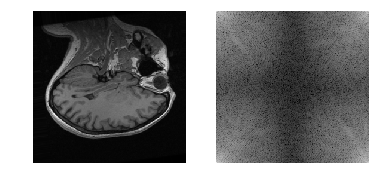

In [8]:
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen2 = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(rec_train[:,:,:,0,np.newaxis], augment=True, seed=seed)
image_datagen2.fit(rec_train[:,:,:,1,np.newaxis], augment=True, seed=seed)

image_generator1 = image_datagen1.flow(rec_train[:,:,:,0,np.newaxis],batch_size = batch_size,seed = seed)
image_generator2 = image_datagen1.flow(rec_train[:,:,:,1,np.newaxis],batch_size = batch_size,seed = seed)

def combine_generator(gen1,gen2,under_mask,stats):
    while True:
        rec_real = gen1.next()
        rec_imag = gen2.next()
        kspace = np.fft.fft2(rec_real[:,:,:,0]+1j*rec_imag[:,:,:,0])
        kspace2 = np.zeros((kspace.shape[0],kspace.shape[1],kspace.shape[2],2))
        rec = np.zeros((kspace.shape[0],kspace.shape[1],kspace.shape[2],2))
        kspace2[:,:,:,0] = kspace.real
        kspace2[:,:,:,1] = kspace.imag
        kspace_under = kspace2.copy()
        kspace_under[:,var_sampling_mask,:] = 0
        kspace_under = (kspace_under-stats[0])/stats[1]#如果用c5d5的结构，不用这一句
#         rec = np.abs(rec_real[:,:,:,0]+1j*rec_imag[:,:,:,0])[:,:,:,np.newaxis]
        rec[:,:,:,0] = (rec_real[:,:,:,0])
        rec[:,:,:,1] = (rec_imag[:,:,:,0])
        yield(kspace_under, [kspace2,rec])

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,image_generator2, var_sampling_mask,stats)


# sample data augmentation
for ii in combined:
    print(ii[1][1].shape)
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[1][1][3,:,:,0],cmap = 'gray')
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(np.log(1+np.abs(ii[1][0][3,:,:,0] + 1j*ii[1][0][3,:,:,1])),cmap = 'gray')
    plt.axis("off")
    plt.show()
    break

In [ ]:
##### training
from keras.callbacks import ReduceLROnPlateau
re_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,mode='auto')
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=rec_train.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (kspace_val,[kspace_val2,rec_val]),
                 callbacks=[checkpoint,earlyStopping,re_lr])

In [7]:
# wnet_c5d5_changedc_cca_cscasde_5_32
import dcwn_1 as dcwn
epochs = 100
batch_size= 4
mask = np.concatenate((var_sampling_mask[:,:,np.newaxis],var_sampling_mask[:,:,np.newaxis]),axis = -1) > 0
mask = mask.astype(np.float32)
model = dcwn.wnet_cca_cscasde_5_32(stats[0],stats[1],stats[2],stats[3],mask,\
                                   kshape = (5,5),kshape2=(3,3))
opt = Adam(lr=1e-3,decay = 1e-6)
model.compile(loss = [dcwn.nrmse,dcwn.nrmse],optimizer=opt, loss_weights=[0.01, 0.99])

model_name = "../Models/wnet_dc" + under_rate +"wnet_c5d5_cca_cscasde_5_32_1d20_12_9_2.hdf5"
if os.path.isfile(model_name):
    model.load_weights(model_name)

print(model.summary())

# Early stopping callback to shut down training after
#10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=15, 
                                       verbose=0, mode='min')

# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                             monitor='val_loss',verbose=0,\
                             save_best_only=True, save_weights_only = True)

E:\pythonenv\env3.6\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


cn1 (?, 256, 256, 2)
ifft2 (?, 256, 256, 2)
o2 (?, 256, 256, 2)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 2)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 2)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 2)  0           lambda_1[0][0]                   
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 256, 256, 2)  0           lambda_2[0][0]                   
_____________________________________________

In [ ]:
##### training
from keras.callbacks import ReduceLROnPlateau
re_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,mode='auto')
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=rec_train.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (kspace_val,[kspace_val2,rec_val]),
                 callbacks=[checkpoint,earlyStopping,re_lr])

In [10]:
# ddd_c10d10_32_dense_block_ca1d_dwt_noshortcut01_cartfirst，DCWN
import dcwn_1 as dcwn
epochs = 100
batch_size= 4
mask = np.concatenate((var_sampling_mask[:,:,np.newaxis],var_sampling_mask[:,:,np.newaxis]),axis = -1) > 0
mask = mask.astype(np.float32)
model = dcwn.ddd_c10d10_32_dense_block_ca1d_dwt_noshortcut01_cartfirst(stats[0],stats[1],stats[2],stats[3],mask,\
                                   kshape = (5,5),kshape2=(3,3))
opt = Adam(lr=1e-3,decay = 1e-6)
model.compile(loss = [dcwn.nrmse,dcwn.nrmse],optimizer=opt, loss_weights=[0.01, 0.99])

model_name = "../Models/wnet_dc" + under_rate +"ddd_c10d10_32_dense_block_ca1d_dwt_noshortcut01_cartfirst_1dR5_2020_1_9.hdf5"
if os.path.isfile(model_name):
    model.load_weights(model_name)

print(model.summary())

# Early stopping callback to shut down training after
#10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=15, 
                                       verbose=0, mode='min')

# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                             monitor='val_loss',verbose=0,\
                             save_best_only=True, save_weights_only = True)

E:\pythonenv\env3.6\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


se shape (?, 32)
se 2 shape (?, 1, 1, 32)
cn1 (?, 256, 256, 2)
se shape (?, 32)
se 2 shape (?, 1, 1, 32)
cn2 (?, 256, 256, 2)
se shape (?, 32)
se 2 shape (?, 1, 1, 32)
cn3 (?, 256, 256, 2)
se shape (?, 32)
se 2 shape (?, 1, 1, 32)
cn4 (?, 256, 256, 2)
se shape (?, 32)
se 2 shape (?, 1, 1, 32)
cn5 (?, 256, 256, 2)
se shape (?, 32)
se 2 shape (?, 1, 1, 32)
cn6 (?, 256, 256, 2)
se shape (?, 32)
se 2 shape (?, 1, 1, 32)
cn7 (?, 256, 256, 2)
se shape (?, 32)
se 2 shape (?, 1, 1, 32)
cn8 (?, 256, 256, 2)
se shape (?, 32)
se 2 shape (?, 1, 1, 32)
cn9 (?, 256, 256, 2)
se shape (?, 32)
se 2 shape (?, 1, 1, 32)
cn10 (?, 256, 256, 2)
o2 (?, 256, 256, 2)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 2)  0                                            
____________________________________________________

In [ ]:
##### training
from keras.callbacks import ReduceLROnPlateau
re_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,mode='auto')
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=rec_train.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (kspace_val,[kspace_val2,rec_val]),
                 callbacks=[checkpoint,earlyStopping,re_lr])